In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI3/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
# !tar -xzf adni1_brain_resid.tar.gz

In [ ]:
# !tar -xzf adni1_brain_stand.tar.gz

In [ ]:
!cat adni3* | tar xzf -

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


In [ ]:
from torchsummary import summary

In [ ]:
encoder = ConvBlock11()
summary(FullNetwork11(encoder), (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
       BatchNorm3d-2       [-1, 32, 37, 37, 44]              64
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
       BatchNorm3d-5       [-1, 16, 18, 18, 22]              32
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
       BatchNorm3d-8          [-1, 8, 9, 9, 11]              16
         MaxPool3d-9           [-1, 8, 4, 4, 5]               0
      ConvBlock11-10           [-1, 8, 4, 4, 5]               0
          Flatten-11                  [-1, 640]               0
           Linear-12                   [-1, 12]           7,692
      BatchNorm1d-13                   [-1, 12]              24
           Linear-14                   

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tuning_df = pd.read_csv('ADNI3_tune.csv').drop('Unnamed: 0', axis=1)
testing_df = pd.read_csv('ADNI3_test.csv').drop('Unnamed: 0', axis=1)

In [ ]:
## if two classes:
tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()


In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDatasetShifted(Dataset):

    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Min Max Scale normalization
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # subsample by the factor of 4
        x_shift = random.randint(-1,1)
        y_shift = random.randint(-1,1)
        z_shift = random.randint(-1,1)
        img_data = np.roll(img_data, (x_shift, y_shift, z_shift), (0, 1, 2))

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (42, 42, 50) -> (50, 42, 42)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)

# Compute weights
total = len(y_train_encoded) + len(y_valid_encoded)
weights = [total/(np.count_nonzero(y_train_encoded == i) + np.count_nonzero(y_valid_encoded == i)) for i in range(len(le.classes_))]
scale = 4

# weighted
weight_encoded = [weights[i] for i in y_train_encoded]
sampler = WeightedRandomSampler(weight_encoded, num_samples=scale*len(y_train_encoded), replacement=True)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDatasetShifted(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDatasetShifted(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,  num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
n_classes

3

In [ ]:
len(train_loader)

227

In [ ]:
len(valid_loader)

7

## loading the pretrained convolutional layer

In [ ]:
!cp /content/drive/MyDrive/Main_Data/Checkpoints3/part2/Auto3dCNN11_ppmi.pth .

In [ ]:
autoencoder = Auto3dCNN11()

filename = 'Auto3dCNN11_ppmi.pth'

if not torch.cuda.is_available():
  checkpoint = torch.load(filename, map_location=torch.device('cpu'))
else:
  checkpoint = torch.load(filename)

autoencoder.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

In [ ]:
import re

encoder_dict = autoencoder.encoder.state_dict()

new_encoder_dict = {}
for k,v in encoder_dict.items():
  layer = int(re.search('\d+', k).group(0)) // 3 + 1
  part = re.search('\..*', k).group(0)
  new_encoder_dict[f'conv{layer}{part}'] = v


In [ ]:
conv_block = ConvBlock11()

conv_block.load_state_dict(new_encoder_dict, strict=False)

_IncompatibleKeys(missing_keys=['batch_norm1.weight', 'batch_norm1.bias', 'batch_norm1.running_mean', 'batch_norm1.running_var', 'batch_norm2.weight', 'batch_norm2.bias', 'batch_norm2.running_mean', 'batch_norm2.running_var', 'batch_norm3.weight', 'batch_norm3.bias', 'batch_norm3.running_mean', 'batch_norm3.running_var'], unexpected_keys=[])

In [ ]:
model = FullNetwork11(encoder=conv_block)

In [ ]:
import os, shutil, re

def prepare_model(filename="Auto3dCNN11_ppmi.pth", num_classes=2):

  if not os.path.isfile(filename):
    shutil.copy(f'/content/drive/MyDrive/Main_Data/Checkpoints3/part2/{filename}', filename)

  autoencoder = Auto3dCNN11()

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  autoencoder.load_state_dict(checkpoint['model_state_dict'], strict=False)

  encoder_dict = autoencoder.encoder.state_dict()

  new_encoder_dict = {}
  for k,v in encoder_dict.items():
    layer = int(re.search('\d+', k).group(0)) // 3 + 1
    part = re.search('\..*', k).group(0)
    new_encoder_dict[f'conv{layer}{part}'] = v

  conv_block = ConvBlock11()

  conv_block.load_state_dict(new_encoder_dict, strict=False)

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(encoder=conv_block, num_classes=num_classes)
  else:
    raise Exception('you should only use 2 or 3 classes for your model.')

  return model

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints3/part2' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = '3c_combined_fullnetwork11_adni3.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = prepare_model(num_classes=3)
model.to(device)

# Number of training epochs
num_epochs = 30

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/227 [00:00<?, ?it/s]

Training Loss: 1.1553
Training Accuracy: 33.01%
Training F1-Score: 31.27%
           AD        CN       MCI
AD   0.450906  0.399916  0.149178
CN   0.435523  0.403487  0.160989
MCI  0.471933  0.392516  0.135551


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1459
Validation Accuracy: 34.40%
Validation F1-Score: 33.72%
           AD        CN       MCI
AD   0.736842  0.210526  0.052632
CN   0.356436  0.504950  0.138614
MCI  0.510204  0.387755  0.102041
Epoch 0: SGD lr 0.000020 -> 0.000020
Epoch 0: saving...
Epoch 1:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1193
Training Accuracy: 37.20%
Training F1-Score: 34.80%
           AD        CN       MCI
AD   0.541081  0.342699  0.116220
CN   0.412464  0.444444  0.143091
MCI  0.467427  0.394137  0.138436


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1529
Validation Accuracy: 32.11%
Validation F1-Score: 33.62%
           AD        CN       MCI
AD   0.631579  0.157895  0.210526
CN   0.465347  0.455446  0.079208
MCI  0.530612  0.346939  0.122449
Epoch 1: SGD lr 0.000020 -> 0.000020
Epoch 1: saving...
Epoch 2:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.1018
Training Accuracy: 39.37%
Training F1-Score: 36.77%
           AD        CN       MCI
AD   0.566093  0.317247  0.116660
CN   0.388978  0.474256  0.136766
MCI  0.452211  0.411368  0.136421


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1369
Validation Accuracy: 37.16%
Validation F1-Score: 37.77%
           AD        CN       MCI
AD   0.578947  0.368421  0.052632
CN   0.316832  0.524752  0.158416
MCI  0.408163  0.418367  0.173469
Epoch 2: SGD lr 0.000020 -> 0.000020
Epoch 2: saving...
Epoch 3:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0891
Training Accuracy: 41.34%
Training F1-Score: 38.45%
           AD        CN       MCI
AD   0.601440  0.297755  0.100805
CN   0.347416  0.504512  0.148072
MCI  0.434765  0.424131  0.141104


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1115
Validation Accuracy: 37.16%
Validation F1-Score: 35.23%
           AD        CN       MCI
AD   0.631579  0.315789  0.052632
CN   0.297030  0.594059  0.108911
MCI  0.469388  0.438776  0.091837
Epoch 3: SGD lr 0.000020 -> 0.000019
Epoch 3: saving...
Epoch 4:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0755
Training Accuracy: 43.66%
Training F1-Score: 40.60%
           AD        CN       MCI
AD   0.617167  0.269099  0.113734
CN   0.302504  0.554120  0.143376
MCI  0.392535  0.462674  0.144791


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1361
Validation Accuracy: 36.70%
Validation F1-Score: 35.08%
           AD        CN       MCI
AD   0.526316  0.368421  0.105263
CN   0.257426  0.613861  0.128713
MCI  0.520408  0.397959  0.081633
Epoch 4: SGD lr 0.000019 -> 0.000019
Epoch 4: saving...
Epoch 5:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0654
Training Accuracy: 43.42%
Training F1-Score: 40.35%
           AD        CN       MCI
AD   0.609787  0.271853  0.118361
CN   0.301792  0.556482  0.141726
MCI  0.394051  0.462510  0.143439


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0985
Validation Accuracy: 34.86%
Validation F1-Score: 35.30%
           AD        CN       MCI
AD   0.421053  0.263158  0.315789
CN   0.237624  0.504950  0.257426
MCI  0.357143  0.469388  0.173469
Epoch 5: SGD lr 0.000019 -> 0.000019
Epoch 5: saving...
Epoch 6:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0468
Training Accuracy: 46.02%
Training F1-Score: 43.29%
           AD        CN       MCI
AD   0.630864  0.245267  0.123868
CN   0.266255  0.577778  0.155967
MCI  0.379195  0.454279  0.166527


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1029
Validation Accuracy: 40.37%
Validation F1-Score: 38.19%
           AD        CN       MCI
AD   0.421053  0.315789  0.263158
CN   0.188119  0.683168  0.128713
MCI  0.418367  0.469388  0.112245
Epoch 6: SGD lr 0.000019 -> 0.000019
Epoch 6: saving...
Epoch 7:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0352
Training Accuracy: 47.25%
Training F1-Score: 44.17%
           AD        CN       MCI
AD   0.652434  0.224167  0.123399
CN   0.250000  0.605305  0.144695
MCI  0.364954  0.473902  0.161143


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1117
Validation Accuracy: 33.49%
Validation F1-Score: 34.89%
           AD        CN       MCI
AD   0.473684  0.368421  0.157895
CN   0.287129  0.475248  0.237624
MCI  0.469388  0.367347  0.163265
Epoch 7: SGD lr 0.000019 -> 0.000019
Epoch 7: saving...
Epoch 8:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0293
Training Accuracy: 47.57%
Training F1-Score: 44.85%
           AD        CN       MCI
AD   0.652766  0.218723  0.128511
CN   0.262901  0.595286  0.141812
MCI  0.346486  0.469790  0.183724


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0671
Validation Accuracy: 38.07%
Validation F1-Score: 37.39%
           AD        CN       MCI
AD   0.263158  0.421053  0.315789
CN   0.198020  0.613861  0.188119
MCI  0.316327  0.520408  0.163265
Epoch 8: SGD lr 0.000019 -> 0.000019
Epoch 8: saving...
Epoch 9:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0179
Training Accuracy: 48.27%
Training F1-Score: 45.85%
           AD        CN       MCI
AD   0.651915  0.216170  0.131915
CN   0.245182  0.599426  0.155392
MCI  0.361303  0.433809  0.204888


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1084
Validation Accuracy: 34.40%
Validation F1-Score: 33.26%
           AD        CN       MCI
AD   0.526316  0.210526  0.263158
CN   0.277228  0.544554  0.178218
MCI  0.418367  0.479592  0.102041
Epoch 9: SGD lr 0.000019 -> 0.000018
Epoch 9: saving...
Epoch 10:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 1.0040
Training Accuracy: 49.67%
Training F1-Score: 47.12%
           AD        CN       MCI
AD   0.669041  0.199413  0.131546
CN   0.216470  0.620465  0.163066
MCI  0.339018  0.461730  0.199251


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1165
Validation Accuracy: 37.16%
Validation F1-Score: 38.86%
           AD        CN       MCI
AD   0.368421  0.526316  0.105263
CN   0.257426  0.504950  0.237624
MCI  0.357143  0.408163  0.234694
Epoch 10: SGD lr 0.000018 -> 0.000018
Epoch 10: saving...
Epoch 11:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9967
Training Accuracy: 50.06%
Training F1-Score: 47.47%
           AD        CN       MCI
AD   0.692340  0.188820  0.118841
CN   0.207888  0.608463  0.183648
MCI  0.336534  0.465971  0.197495


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0928
Validation Accuracy: 39.45%
Validation F1-Score: 38.49%
           AD        CN       MCI
AD   0.631579  0.263158  0.105263
CN   0.257426  0.594059  0.148515
MCI  0.418367  0.438776  0.142857
Epoch 11: SGD lr 0.000018 -> 0.000018
Epoch 11: saving...
Epoch 12:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9959
Training Accuracy: 49.65%
Training F1-Score: 47.42%
           AD        CN       MCI
AD   0.671530  0.190079  0.138391
CN   0.222452  0.602559  0.174990
MCI  0.327002  0.455822  0.217176


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0597
Validation Accuracy: 43.12%
Validation F1-Score: 45.41%
           AD        CN       MCI
AD   0.473684  0.210526  0.315789
CN   0.257426  0.574257  0.168317
MCI  0.377551  0.346939  0.275510
Epoch 12: SGD lr 0.000018 -> 0.000018
Epoch 12: saving...
Epoch 13:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9810
Training Accuracy: 50.97%
Training F1-Score: 48.77%
           AD        CN       MCI
AD   0.696399  0.174204  0.129397
CN   0.221027  0.599761  0.179211
MCI  0.327505  0.449467  0.223028


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0978
Validation Accuracy: 35.32%
Validation F1-Score: 35.66%
           AD        CN       MCI
AD   0.526316  0.105263  0.368421
CN   0.257426  0.504950  0.237624
MCI  0.387755  0.448980  0.163265
Epoch 13: SGD lr 0.000018 -> 0.000018
Epoch 13: saving...
Epoch 14:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9761
Training Accuracy: 51.64%
Training F1-Score: 49.13%
           AD        CN       MCI
AD   0.718935  0.165258  0.115807
CN   0.211587  0.620487  0.167926
MCI  0.306490  0.468349  0.225160


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0744
Validation Accuracy: 42.66%
Validation F1-Score: 44.73%
           AD        CN       MCI
AD   0.473684  0.263158  0.263158
CN   0.247525  0.564356  0.188119
MCI  0.367347  0.357143  0.275510
Epoch 14: SGD lr 0.000018 -> 0.000018
Epoch 14: saving...
Epoch 15:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9806
Training Accuracy: 51.19%
Training F1-Score: 49.16%
           AD        CN       MCI
AD   0.702109  0.164012  0.133879
CN   0.215267  0.596527  0.188207
MCI  0.319836  0.434765  0.245399


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0671
Validation Accuracy: 39.45%
Validation F1-Score: 40.68%
           AD        CN       MCI
AD   0.578947  0.210526  0.210526
CN   0.217822  0.514851  0.267327
MCI  0.397959  0.367347  0.234694
Epoch 15: SGD lr 0.000018 -> 0.000017
Epoch 15: saving...
Epoch 16:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9540
Training Accuracy: 53.49%
Training F1-Score: 51.54%
           AD        CN       MCI
AD   0.727729  0.144291  0.127980
CN   0.205798  0.613312  0.180890
MCI  0.302829  0.433860  0.263311


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0746
Validation Accuracy: 38.99%
Validation F1-Score: 39.51%
           AD        CN       MCI
AD   0.473684  0.263158  0.263158
CN   0.217822  0.544554  0.237624
MCI  0.336735  0.448980  0.214286
Epoch 16: SGD lr 0.000017 -> 0.000017
Epoch 16: saving...
Epoch 17:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9627
Training Accuracy: 52.18%
Training F1-Score: 50.02%
           AD        CN       MCI
AD   0.719732  0.145371  0.134897
CN   0.212146  0.605263  0.182591
MCI  0.309175  0.453289  0.237537


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0741
Validation Accuracy: 37.16%
Validation F1-Score: 37.84%
           AD        CN       MCI
AD   0.526316  0.157895  0.315789
CN   0.168317  0.485149  0.346535
MCI  0.357143  0.418367  0.224490
Epoch 17: SGD lr 0.000017 -> 0.000017
Epoch 17: saving...
Epoch 18:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9556
Training Accuracy: 53.71%
Training F1-Score: 52.01%
           AD        CN       MCI
AD   0.727389  0.142251  0.130361
CN   0.195093  0.604586  0.200322
MCI  0.291719  0.427382  0.280899


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0569
Validation Accuracy: 40.83%
Validation F1-Score: 41.72%
           AD        CN       MCI
AD   0.473684  0.263158  0.263158
CN   0.188119  0.544554  0.267327
MCI  0.326531  0.418367  0.255102
Epoch 18: SGD lr 0.000017 -> 0.000017
Epoch 18: saving...
Epoch 19:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9493
Training Accuracy: 53.37%
Training F1-Score: 51.60%
           AD        CN       MCI
AD   0.711836  0.139691  0.148473
CN   0.178764  0.622978  0.198258
MCI  0.299754  0.429156  0.271089


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0582
Validation Accuracy: 42.20%
Validation F1-Score: 42.87%
           AD        CN       MCI
AD   0.473684  0.263158  0.263158
CN   0.188119  0.594059  0.217822
MCI  0.357143  0.408163  0.234694
Epoch 19: SGD lr 0.000017 -> 0.000017
Epoch 19: saving...
Epoch 20:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9487
Training Accuracy: 52.90%
Training F1-Score: 51.09%
           AD        CN       MCI
AD   0.729730  0.125388  0.144883
CN   0.189750  0.600156  0.210094
MCI  0.294529  0.437680  0.267791


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0515
Validation Accuracy: 36.24%
Validation F1-Score: 35.24%
           AD        CN       MCI
AD   0.526316  0.263158  0.210526
CN   0.158416  0.554455  0.287129
MCI  0.408163  0.459184  0.132653
Epoch 20: SGD lr 0.000017 -> 0.000017
Epoch 20: saving...
Epoch 21:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9389
Training Accuracy: 54.20%
Training F1-Score: 52.79%
           AD        CN       MCI
AD   0.721888  0.136481  0.141631
CN   0.182634  0.604158  0.213208
MCI  0.279561  0.410809  0.309630


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0371
Validation Accuracy: 42.20%
Validation F1-Score: 41.10%
           AD        CN       MCI
AD   0.473684  0.315789  0.210526
CN   0.158416  0.643564  0.198020
MCI  0.336735  0.479592  0.183673
Epoch 21: SGD lr 0.000017 -> 0.000016
Epoch 21: saving...
Epoch 22:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9382
Training Accuracy: 53.69%
Training F1-Score: 52.16%
           AD        CN       MCI
AD   0.728051  0.126767  0.145182
CN   0.183797  0.595728  0.220476
MCI  0.285832  0.421334  0.292834


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0534
Validation Accuracy: 42.20%
Validation F1-Score: 42.16%
           AD        CN       MCI
AD   0.315789  0.157895  0.526316
CN   0.099010  0.613861  0.287129
MCI  0.285714  0.469388  0.244898
Epoch 22: SGD lr 0.000016 -> 0.000016
Epoch 22: saving...
Epoch 23:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9319
Training Accuracy: 54.35%
Training F1-Score: 52.79%
           AD        CN       MCI
AD   0.726357  0.132662  0.140981
CN   0.175501  0.615234  0.209266
MCI  0.290924  0.414422  0.294654


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0519
Validation Accuracy: 38.99%
Validation F1-Score: 38.91%
           AD        CN       MCI
AD   0.421053  0.368421  0.210526
CN   0.138614  0.554455  0.306931
MCI  0.316327  0.469388  0.214286
Epoch 23: SGD lr 0.000016 -> 0.000016
Epoch 23: saving...
Epoch 24:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9092
Training Accuracy: 56.82%
Training F1-Score: 55.33%
           AD        CN       MCI
AD   0.748870  0.115495  0.135635
CN   0.154895  0.640644  0.204461
MCI  0.264435  0.424686  0.310879


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0322
Validation Accuracy: 43.58%
Validation F1-Score: 43.50%
           AD        CN       MCI
AD   0.421053  0.263158  0.315789
CN   0.128713  0.623762  0.247525
MCI  0.306122  0.448980  0.244898
Epoch 24: SGD lr 0.000016 -> 0.000016
Epoch 24: saving...
Epoch 25:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9225
Training Accuracy: 55.37%
Training F1-Score: 54.03%
           AD        CN       MCI
AD   0.751300  0.120017  0.128683
CN   0.168665  0.595124  0.236211
MCI  0.264996  0.411257  0.323747


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0509
Validation Accuracy: 43.12%
Validation F1-Score: 44.06%
           AD        CN       MCI
AD   0.473684  0.315789  0.210526
CN   0.168317  0.584158  0.247525
MCI  0.346939  0.387755  0.265306
Epoch 25: SGD lr 0.000016 -> 0.000016
Epoch 25: saving...
Epoch 26:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9098
Training Accuracy: 55.88%
Training F1-Score: 54.42%
           AD        CN       MCI
AD   0.746667  0.113333  0.140000
CN   0.172962  0.617097  0.209940
MCI  0.261486  0.436239  0.302276


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0337
Validation Accuracy: 38.99%
Validation F1-Score: 38.89%
           AD        CN       MCI
AD   0.473684  0.210526  0.315789
CN   0.108911  0.534653  0.356436
MCI  0.306122  0.469388  0.224490
Epoch 26: SGD lr 0.000016 -> 0.000016
Epoch 26: saving...
Epoch 27:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9162
Training Accuracy: 55.04%
Training F1-Score: 53.82%
           AD        CN       MCI
AD   0.738877  0.115593  0.145530
CN   0.165503  0.593018  0.241478
MCI  0.250416  0.430948  0.318636


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0359
Validation Accuracy: 43.12%
Validation F1-Score: 43.81%
           AD        CN       MCI
AD   0.368421  0.263158  0.368421
CN   0.198020  0.603960  0.198020
MCI  0.275510  0.459184  0.265306
Epoch 27: SGD lr 0.000016 -> 0.000015
Epoch 27: saving...
Epoch 28:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9094
Training Accuracy: 56.34%
Training F1-Score: 54.95%
           AD        CN       MCI
AD   0.763597  0.104925  0.131478
CN   0.159583  0.609062  0.231355
MCI  0.254658  0.422774  0.322567


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0462
Validation Accuracy: 44.95%
Validation F1-Score: 45.20%
           AD        CN       MCI
AD   0.473684  0.263158  0.263158
CN   0.168317  0.643564  0.188119
MCI  0.336735  0.418367  0.244898
Epoch 28: SGD lr 0.000015 -> 0.000015
Epoch 28: saving...
Epoch 29:


  0%|          | 0/227 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.8967
Training Accuracy: 57.41%
Training F1-Score: 56.18%
           AD        CN       MCI
AD   0.757315  0.099398  0.143287
CN   0.140415  0.631665  0.227920
MCI  0.250102  0.406009  0.343890


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0338
Validation Accuracy: 42.66%
Validation F1-Score: 43.22%
           AD        CN       MCI
AD   0.421053  0.210526  0.368421
CN   0.108911  0.584158  0.306931
MCI  0.326531  0.408163  0.265306
Epoch 29: SGD lr 0.000015 -> 0.000015
Epoch 29: saving...


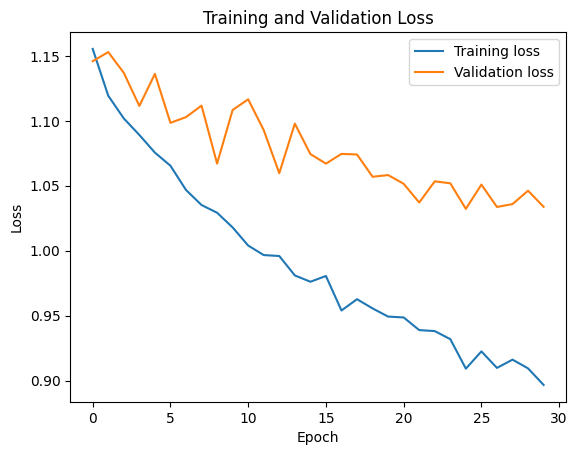

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()